Main resource: https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_7_TRAINING_A_MODEL.md

# Flair import

In [1]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

2021-04-26 19:18:27,014 loading file C:\Users\magab\.flair\models\sentiment-en-mix-distillbert_4.pt


In [2]:
sentence = Sentence('Flair is nice')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

Sentence above is:  [POSITIVE (0.993)]


In [3]:
import flair
import numpy as np
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
flair.device = device

print(flair.device)

cuda


In [4]:
print(torch.__version__)

1.7.1+cu110


In [5]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

data_folder = '../data/corpus_10042021'
column_name_map = {1: "text", 2: "label_topic"}

# 1. get the corpus
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True) 

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

print(label_dict)

2021-04-26 19:18:36,631 Reading data from ..\data\corpus_10042021
2021-04-26 19:18:36,632 Train: ..\data\corpus_10042021\train.csv
2021-04-26 19:18:36,633 Dev: ..\data\corpus_10042021\dev.csv
2021-04-26 19:18:36,633 Test: ..\data\corpus_10042021\test.csv
2021-04-26 19:18:36,670 Computing label dictionary. Progress:


100%|██████████████████████████████████████████████████████████████████████████████████| 976/976 [00:01<00:00, 872.01it/s]

2021-04-26 19:18:55,324 [b'High', b'Low', b'Medium']
Dictionary with 3 tags: High, Low, Medium


In [6]:
# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'),
                   FlairEmbeddings('news-forward'),
                   FlairEmbeddings('news-backward')]

# 4. initialize document embedding by passing list of word embeddings
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=256, bidirectional=True,rnn_type="LSTM")

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('./flair/bilstm',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              train_with_dev=True,
              patience=3,
              max_epochs=10,
              monitor_test=True,
              embeddings_storage_mode='gpu')

2021-04-26 19:18:58,429 ----------------------------------------------------------------------------------------------------
2021-04-26 19:18:58,430 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.05, inplace=False)
          (encoder): Embedding(300, 100)
          (rnn): LSTM(100, 2048)
          (decoder): Linear(in_features=2048, out_features=300, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=4196, out_features=4196, bias=True)
    (rnn): LSTM(4196, 256,

{'test_score': 0.3303,
 'dev_score_history': [],
 'train_loss_history': [1.1466083507384024,
  1.1023241569918971,
  1.1088579912339487,
  1.0979239075414595,
  1.06239547844856,
  1.0695928489008257,
  1.0595164068283573,
  1.0701790567367309,
  1.0424021001785033,
  1.0444190982849366],
 'dev_loss_history': []}

2021-04-26 19:55:37,526 ----------------------------------------------------------------------------------------------------
2021-04-26 19:55:37,527 WARNING: No F1 found for test split in this data.
2021-04-26 19:55:37,527 Are you sure you want to plot F1 and not another value?
2021-04-26 19:55:37,528 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


Loss and F1 plots are saved in flair\bilstm\training.png


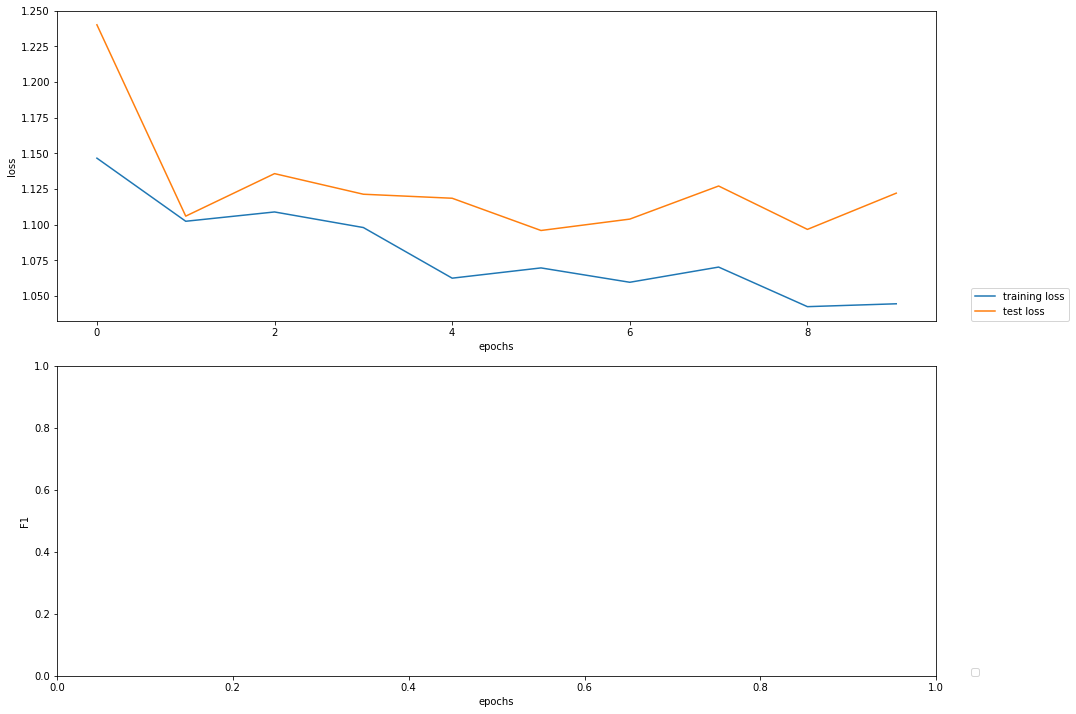

In [8]:
# visualize
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('./flair/bilstm/loss.tsv')

#This generates PNG plots in the result folder.

In [41]:
test_csv = pd.read_csv('../data/corpus_10042021/test.csv')
test_csv.head()

,Unnamed: 0,Response,Concrete
0,397,Feeling isolated and very fearful at beginni...,Medium
1,32,1. I feel isolated and lonely. \n2. I call my ...,Medium
2,360,I make an effort to message people and suggest...,Low
3,321,I would like to feel more connected to other p...,Low
4,258,I take the time to write out a message to my f...,Medium


In [49]:
test_data = []
target = []
preds = []

for i, item in test_csv.iterrows():
    test_data.append(Sentence(item.Response))
    target.append(item.Concrete)
    
classifier.predict(test_data, mini_batch_size=4)

for item in test_data:
    preds.append(item.labels[0].value)

C:\Users\magab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['Low', 'Medium', 'High'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


[Text(0, 0.5, 'Low'), Text(0, 1.5, 'Medium'), Text(0, 2.5, 'High')]

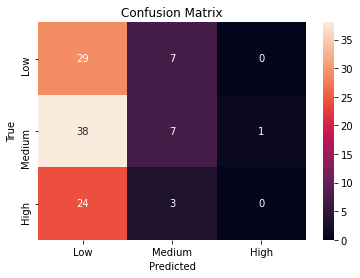

In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Low', 'Medium', 'High']
cm = confusion_matrix(target, preds, labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [67]:
print(cm)

[[29  7  0]
 [38  7  1]
 [24  3  0]]
